In [1]:
import argparse
import os, sys
import time
import datetime

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm

#Simplenet model
from model import simplenet

# You cannot change this line.
from tools.dataloader import CIFAR10

In [2]:
# Setting some hyperparameters
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 1e-3
EPOCHS = 220
DATAROOT = "./data"
CHECKPOINT_PATH = "./saved_model"

#Record Runtime Data
logs = {'epochs':[], 'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

**Your answer:**

In [3]:

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose(
    [    
        transforms.RandomCrop(32,padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
     transforms.Normalize(mean, std)])

transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)])

In [4]:
# Call the dataset Loader
trainset = CIFAR10(root=DATAROOT, train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=1)
valset = CIFAR10(root=DATAROOT, train=False, download=False, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=1)

In [5]:
# Specify the device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = simplenet()
net = net.to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


In [6]:
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = True
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_model/model.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    net.load_state_dict(ckpt['net'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

Training from scratch ...
Starting from learning rate 0.100000:


In [7]:
# Create loss function and specify regularization
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = torch.optim.Adadelta(net.parameters(), lr=INITIAL_LR, rho=0.9, eps=1e-3, weight_decay=REG)

In [ ]:
"""
Assignment 3(a)
Start the training process over the whole CIFAR-10 training dataset. 
For sanity check, you are required to report the initial loss value at 
the beginning of the training process and briefly justify this value. 
Run the training process for \textbf{a maximum of 30} epochs and you 
should be able to reach around \textbf{65\%} accuracy on the validation 
dataset.
"""

# Report Initial Loss
val_loss = 0
net.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(valloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output from the DNN.
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss
avg_loss = val_loss / len(valloader)
print("Initial loss: %.4f" % (avg_loss))


# Start the training/validation process
# The process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
global_step = 0
best_val_acc = 0

for i in range(start_epoch, EPOCHS):
    print(datetime.datetime.now())
    logs['epochs'].append(i)

    # Switch to train mode
    net.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    # Train the training dataset for 1 epoch.
    print(len(trainloader))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        # Calculate accuracy
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()

        train_loss += loss

        global_step += 1
        if global_step % 100 == 0:
            avg_loss = train_loss / (batch_idx + 1)
        pass
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Validation...")
    total_examples = 0
    correct_examples = 0

    #Logging the training metrics
    logs['train_loss'].append(avg_loss)
    logs['train_acc'].append(avg_acc)

    net.eval()

    val_loss = 0
    val_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # Calculate predicted labels
            _, predicted = outputs.max(1)
            # Calculate accuracy
            total_examples += targets.size(0)
            correct_examples += (predicted==targets).sum().item()
            val_loss += loss

    avg_loss = val_loss / len(valloader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    #Logging the training metrics
    logs['val_loss'].append(avg_loss)
    logs['val_acc'].append(avg_acc)
    
    if i<50:
        current_learning_rate = INITIAL_LR
    elif i<100:
        current_learning_rate = INITIAL_LR * 0.5
    elif i<180:
        current_learning_rate = INITIAL_LR * 0.1
    else:
        current_learning_rate = INITIAL_LR * 0.01
        
    for param_group in optimizer.param_groups:
        # Assign the learning rate parameter
        param_group['lr'] = current_learning_rate

    print("Current learning rate is %f" %current_learning_rate)

    # Save for checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'model.h5'))

print("Optimization finished.")

with open('training_kaggle.csv', 'w') as f:
    f.write('epochs, train_loss, val_loss, train_acc, val_acc\n')
    for i in range(len(logs['epochs'])):
        f.write("%d,%f,%f,%f,%f\n"%(logs['epochs'][i], logs['train_loss'][i], logs['val_loss'][i], logs['train_acc'][i], logs['val_acc'][i]))

Initial loss: 2.3108
2019-09-30 01:01:09.390992
Epoch 0:
352
Training loss: 1.7357, Training accuracy: 0.3826
2019-09-30 01:01:46.848720
Validation...
Validation loss: 1.4254, Validation accuracy: 0.4800
Current learning rate is 0.100000
Saving ...
2019-09-30 01:01:48.567511
Epoch 1:
352
Training loss: 1.2395, Training accuracy: 0.5509
2019-09-30 01:02:16.215741
Validation...
Validation loss: 1.2755, Validation accuracy: 0.5428
Current learning rate is 0.100000
Saving ...
2019-09-30 01:02:18.021018
Epoch 2:
352
Training loss: 1.0190, Training accuracy: 0.6392
2019-09-30 01:02:45.756180
Validation...
Validation loss: 0.9246, Validation accuracy: 0.6688
Current learning rate is 0.100000
Saving ...
2019-09-30 01:02:47.585321
Epoch 3:
352
Training loss: 0.8584, Training accuracy: 0.6952
2019-09-30 01:03:15.314040
Validation...
Validation loss: 0.7680, Validation accuracy: 0.7296
Current learning rate is 0.100000
Saving ...
2019-09-30 01:03:17.134080
Epoch 4:
352
Training loss: 0.7539, Trai

In [11]:
import numpy as np
#Output test result
test_img = np.load("./data/cifar10-batches-images-test.npy")
net.eval()
id_list = []
for i in tqdm(range(test_img.shape[0])):
    with torch.no_grad():
        inputs = transform_val(test_img[i, :, :, :]).unsqueeze(0)
        inputs = inputs.to(device)
        predicted = net(inputs)
        _, prediction = torch.max(predicted, 1)
        id_list.append(prediction.item())  



tensor([0], device='cuda:0')


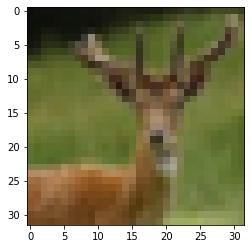

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
a = 25
net.eval()

inputs = transform_val(test_img[a, :, :, :]).unsqueeze(0)
inputs = inputs.to(device)
predicted = net(inputs)
_, prediction = torch.max(predicted, 1)
plt.imshow(test_img[a, :, :, :])
print(prediction)

In [14]:
with open("submission.csv", "w") as f:
    f.write("Id,Category\n")
    for i in tqdm(range(len(id_list))):
        f.write("%d,%d\n"%(i, id_list[i]))
    